# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it


Computer vision-based object detection techniques can be applied in super market settings to build a system that can identify products on store shelves.
An example of how this system could be used would be to assist visually impaired customers or automate common store management tasks like detecting low-stock or misplaced products, given an image of a shelf in a store.

## Task
Develop a computer vision system that, given a reference image for each product, is able to identify such product from one picture of a store shelf.

<figure>
<a href="https://imgbb.com/">
  <center>
  <img src="https://i.ibb.co/TwkMWnH/Screenshot-2024-04-04-at-14-54-51.png" alt="Screenshot-2024-04-04-at-14-54-51" border="0" width="300" />
</a>
</figure>

For each type of product displayed in the
shelf the system should report:
1. Number of instances;
1. Dimension of each instance (width and height in pixel of the bounding box that enclose them);
1. Position in the image reference system of each instance (center of the bounding box that enclose them).

#### Example of expected output
```
Product 0 - 2 instance found:
  Instance 1 {position: (256, 328), width: 57px, height: 80px}
  Instance 2 {position: (311, 328), width: 57px, height: 80px}
Product 1 – 1 instance found:
.
.
.
```

### Track A - Single Instance Detection
Develop an object detection system to identify single instance of products given one reference image for each item and a scene image.

The system should be able to correctly identify all the product in the shelves
image.

### Track B - Multiple Instances Detection
In addition to what achieved at step A, the system should also be able to detect multiple instances of the same product.

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify.
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios. The images contained in this folder are corrupted by noise.

#### Track A - Single Instance Detection
* **Models**: {ref1.png to ref14.png}.
* **Scenes**: {scene1.png to scene5.png}.

#### Track B - Multiple Instances Detection
* **Models**: {ref15.png to ref27.png}.
* **Scenes**: {scene6.png to scene12.png}.

In [31]:
# from google.colab import drive
# drive.mount('/content/drive')

# !cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
# !unzip dataset.zip

## Evaluation criteria
1. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

2. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed approach.

In [200]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [410]:
from InstanceMatcher import InstanceMatcher
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob

In [416]:
def display_scenes_with_boxes(filenames, all_boxes, ncols=3):
    nrows = (len(filenames) + ncols - 1) // ncols
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
    axs = axs.flatten()

    for ax, filename, boxes in zip(axs, filenames, all_boxes):
        img = cv.cvtColor(cv.imread(filename), cv.COLOR_BGR2RGB)
        for box in boxes:
            img = cv.rectangle(img, box.get_pt1(), box.get_pt2(), (0,255,0), 20)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(filename.split('/')[-1])

    for ax in axs[len(filenames):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    
def process_scenes(filenames, matcher):
    all_instances = []
    all_boxes = []
    
    for f in filenames:
        instances, boxes = matcher.match(f, 100)
        # Extract the filename without the path or file extension
        all_instances.append([i.split('/')[-1].split('.')[0] for i in instances])
        all_boxes.append(boxes)
        
    return all_instances, all_boxes

def calculate_accuracy(found, ground_truth):
    total_matches = 0
    total_ground_truth = sum(len(true) for true in ground_truth)
    
    for pred, true in zip(found, ground_truth):
        matches = set(pred) & set(true)
        total_matches += len(matches)
    
    return total_matches / total_ground_truth if total_ground_truth > 0 else 0

def sharpen(img, k, sigma):
    m = (2 * int(3 * sigma) + 1)
    g = cv.getGaussianKernel(m, sigma)
    F_b = np.outer(g, g)
    F_id = np.zeros((m, m)); 
    F_id[m // 2, m // 2] = 1
    sharpen_filter = F_id + k * (F_id - F_b)
    return cv.filter2D(img, -1, sharpen_filter)

## Track A

In [365]:
ground_truth = [
    ["ref1", "ref2"],    # Scene 1
    ["ref3", "ref4", "ref5"],    # Scene 2
    ["ref6", "ref7", "ref8"],    # Scene 3
    ["ref1", "ref7", "ref8", "ref9", "ref10"],    # Scene 4
    ["ref11", "ref12"]    # Scene 5
]

In [352]:
filenames = sorted(glob.glob("./dataset/scenes/trackA/*.png"))

# GRID SEARCH
preprocessings = [
    # [lambda img: cv.medianBlur(img, 3)],
    # [lambda img: cv.medianBlur(img, 3), lambda img: cv.bilateralFilter(img,9,75,75)],
    [lambda img: cv.medianBlur(img, 3), lambda img: cv.fastNlMeansDenoisingColored(img, None)],
    # [lambda img: cv.medianBlur(img, 3), lambda img: cv.fastNlMeansDenoisingColored(img, None), lambda img: sharpen(img, 0.5, 1)],
    # [lambda img: cv.medianBlur(img, 3), lambda img: cv.fastNlMeansDenoisingColored(img, None), lambda img: sharpen(img, 0.5, 1.5)],
    # [lambda img: cv.medianBlur(img, 3), lambda img: cv.fastNlMeansDenoisingColored(img, None), lambda img: sharpen(img, 0.75, 1)],
    # [lambda img: cv.medianBlur(img, 7)],
    # [lambda img: cv.medianBlur(img, 11)],
]

results = []
for preprocessing in preprocessings:
    matcher = InstanceMatcher('./dataset/models/trackA/', preprocessing_steps=preprocessing)
    all_instances, _ = process_scenes(filenames, matcher)
    accuracy = calculate_accuracy(all_instances, ground_truth)    
    results.append((preprocessing, accuracy))

results

[([<function __main__.<lambda>(img)>, <function __main__.<lambda>(img)>], 0.6)]

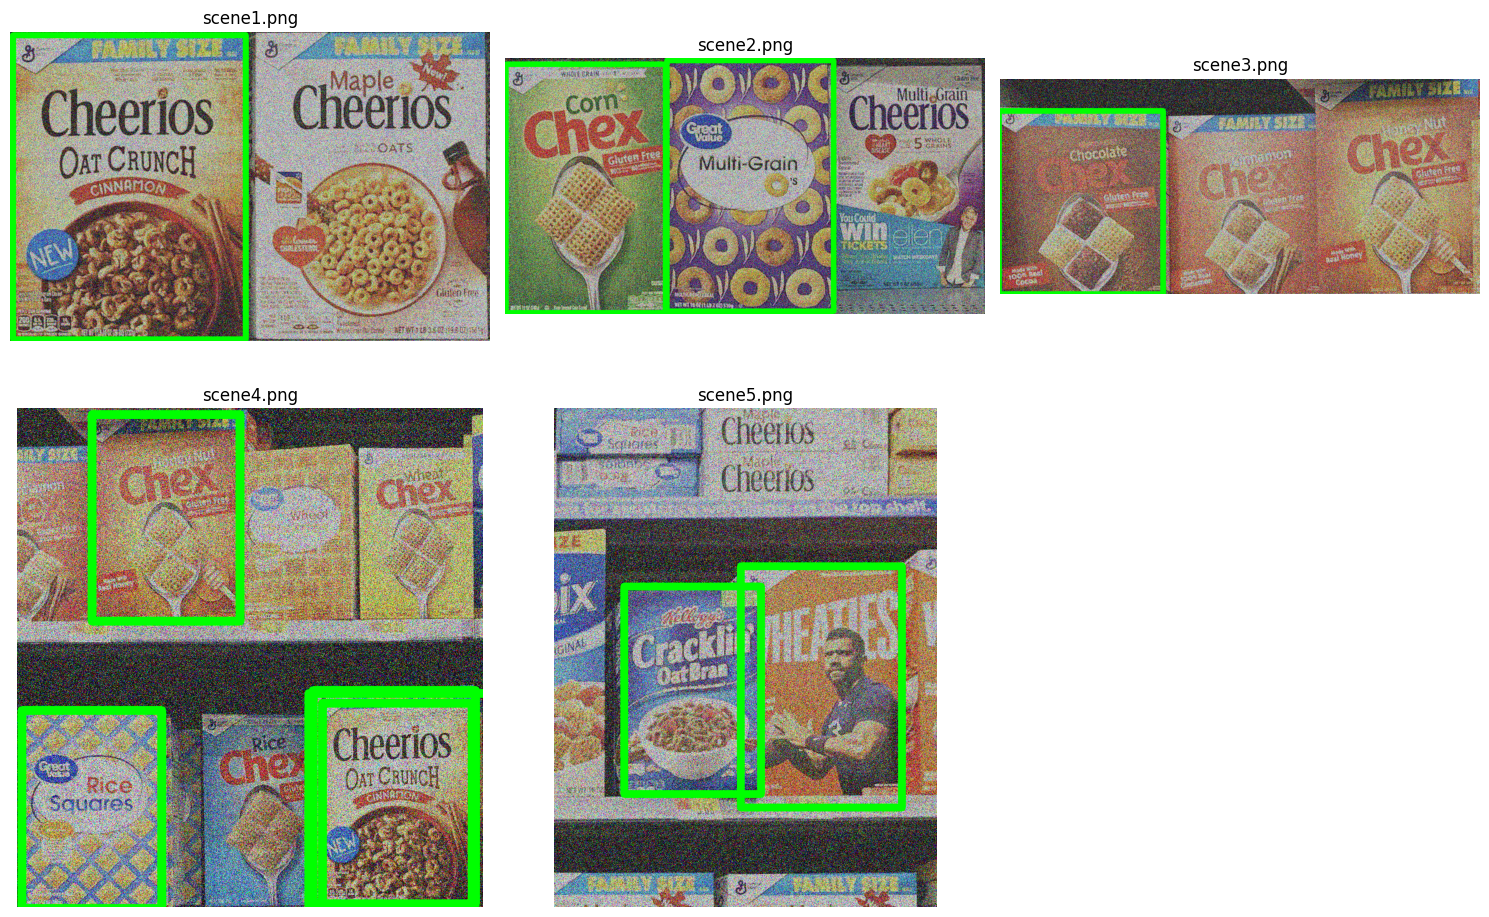

In [417]:
matcher = InstanceMatcher('./dataset/models/trackA', preprocessing_steps=
                          [lambda img: cv.medianBlur(img, 3), lambda img: cv.fastNlMeansDenoisingColored(img, None)]
                         )
_, all_boxes = process_scenes(filenames, matcher)
display_scenes_with_boxes(filenames, all_boxes)

## Track B

In [ ]:
ground_truth = [
    ["ref15", "ref15"],    # Scene 6
    ["ref16", "ref16"],    # Scene 7
    ["ref17", "ref17", "ref23", "ref23", "ref24", "ref27"],    # Scene 8
    ["ref18", "ref19", "ref19", "ref20", "ref20"],    # Scene 9
    ["ref21", "ref21", "ref22", "ref22"],    # Scene 10
    ["ref23", "ref23", "ref24", "ref24", "ref25", "ref25"],    # Scene 11
    ["ref26", "ref26", "ref27", "ref27", "ref18", "ref18"]    # Scene 12
]

In [ ]:
matcher = InstanceMatcher('./dataset/models/trackB/')
display_images('./dataset/scenes/trackB', matcher)